In [181]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import seaborn as sb
%pylab inline

from pylab import rcParams
rcParams['figure.figsize'] = 20, 14
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# Читаем и преобразовываем JSON

In [50]:
with open('v8_20AA_1bee.json', encoding='utf8') as data_file:
    json_data = json.load(data_file)

In [81]:
_columns=[val['Name']['#value'] for val in json_data['#value']['column']]#Вычленяем колонки
data=pd.DataFrame(data=json_data['#value']['row'], columns=_columns).apply(lambda row: [val['#value'] for val in row])#читаем JSON и вычленяем значения
data['Дата']=pd.to_datetime(data['Дата'],format='%Y-%m-%d')#преобразуем дату

del json_data


# Формируем новые характеристики

In [91]:
data['Год']=data['Дата'].dt.year
data['Неделя']=data['Дата'].dt.week
data.head()

,Дата,Товар,АртикулБезКачества,ВидИзделия,ПодвидИзделия,СтильДизайна,ВидДизайна,ПодвидДизайна,ОсновнойКамень,ГруппаТовара,...,ЦветМеталла,ЦветПокрытия,ТоварСреднийВес,ТоварТип,Размер,Количество,Вес,НеЗаказыватьУПоставщиков,Год,Неделя
0,2017-01-21 19:20:37,Кольцо с фианитом и эмалью 94011135,94011135,Кольцо,Прочие кольца,Fashion,Цветники - одинарники,,Фианит,4 группа,...,Серебро,,14.407,Весовой,20.0,1,4.26,True,2017,3
1,2017-01-21 19:20:37,Кольцо с фианитом и эмалью 94011135,94011135,Кольцо,Прочие кольца,Fashion,Цветники - одинарники,,Фианит,4 группа,...,Серебро,,5.885,Весовой,20.0,1,4.26,True,2017,3
2,2017-01-13 19:31:16,Серьги С-СЛ-5184-Фбел,С-СЛ-5184-Фбел,Серьги,Серьги с англ. замком,Classic,Цветники - одинарники,,Фианит,4 группа,...,Серебро,,4.974,Штучный,0.0,1,4.03,False,2017,2
3,2017-01-23 11:56:54,Серьги с фианитом и эмалью R2AF4G002000,R2AF4G002000,Серьги,Серьги с англ. замком,Fashion,Восток,,Фианит,4 группа,...,Серебро,,7.409,Штучный,0.0,1,7.48,False,2017,4
4,2017-01-23 11:56:54,Серьги с фианитом и эмалью R2AF4G002000,R2AF4G002000,Серьги,Серьги с англ. замком,Fashion,Восток,,Фианит,4 группа,...,Серебро,,5.078,Штучный,0.0,1,7.48,False,2017,4


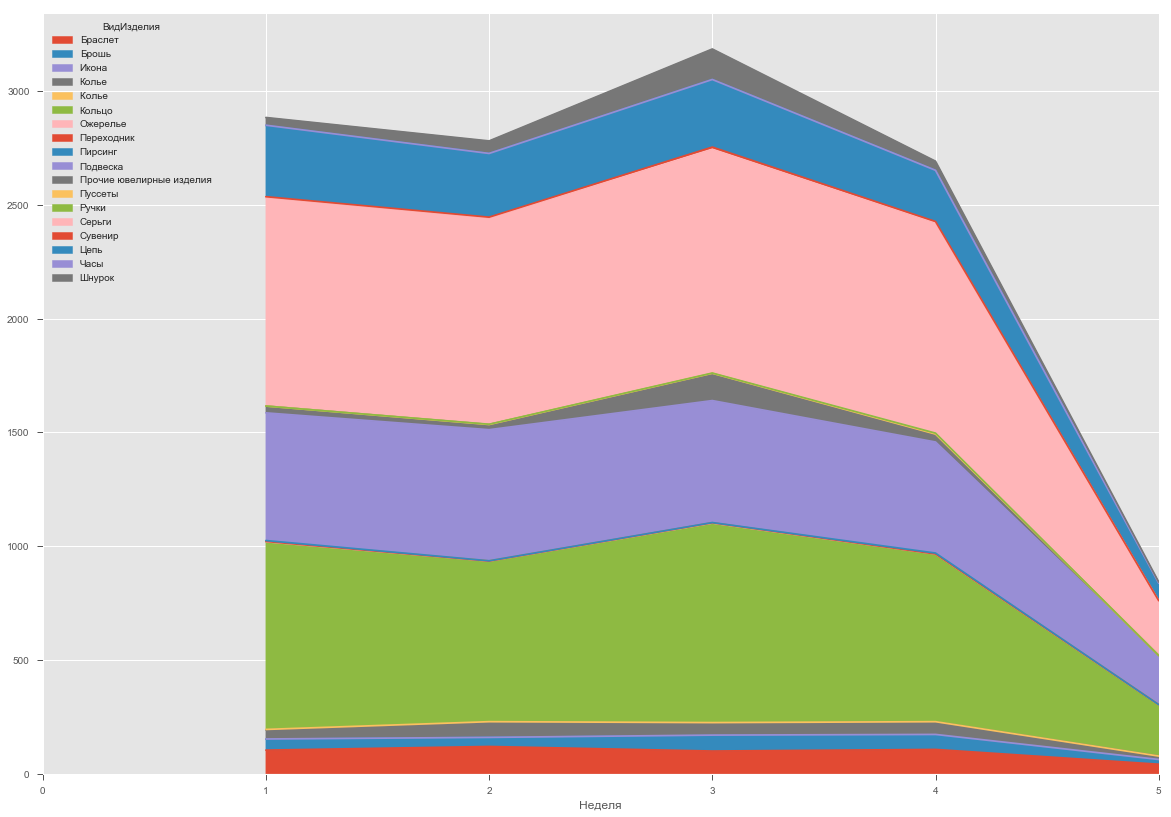

In [197]:
data.pivot_table(index='Неделя', columns='ВидИзделия', values='Количество', aggfunc=np.sum,fill_value=0,dropna=False).plot(kind='area',xlim=[0,5], legend=True,stacked=True)





In [194]:
data.pivot_table(index='Неделя', columns='ВидИзделия', values='Количество', aggfunc=np.sum,fill_value=0,dropna=False)

ВидИзделия,Браслет,Брошь,Икона,Колье,Колье,Кольцо,Ожерелье,Переходник,Пирсинг,Подвеска,Прочие ювелирные изделия,Пуссеты,Ручки,Серьги,Сувенир,Цепь,Часы,Шнурок
Неделя,,,,,,,,,,,,,,,,,,
1,104,48,1,40,2,825,0,1,4,561,30,0,0,916,4,313,1,34
2,120,40,0,66,3,706,0,0,1,576,23,0,1,906,4,280,0,55
3,100,68,2,50,5,876,1,1,1,536,119,1,1,984,9,297,0,134
4,107,64,2,55,1,737,0,0,4,488,35,0,4,924,6,225,0,40
5,42,19,2,15,0,226,0,0,0,214,2,0,0,240,1,77,0,5
52,0,0,0,1,0,26,0,0,1,21,3,0,0,36,1,14,0,0


In [195]:
_columns

['Дата',
 'Товар',
 'АртикулБезКачества',
 'ВидИзделия',
 'ПодвидИзделия',
 'СтильДизайна',
 'ВидДизайна',
 'ПодвидДизайна',
 'ОсновнойКамень',
 'ГруппаТовара',
 'Коллекция',
 'МаркетинговаяЛинейка',
 'ЦветМеталла',
 'ЦветПокрытия',
 'ТоварСреднийВес',
 'ТоварТип',
 'Размер',
 'Количество',
 'Вес',
 'НеЗаказыватьУПоставщиков']